In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

import viz 

# use the style file
plt.style.use('style.mpl')

colors = viz.color_palette()
color_name_order = 'dark_blue,light_green,purple,yellow,red,light_blue,pale_green,dark_purple,yellow,light_red'.split(',')
color_order = [colors[n] for n in color_name_order]

In [4]:
# input
np.random.seed(1234)
J_t = np.random.normal(10, 2, 2000)

# tri-exponential decay in age
def decay(G_0, ages):
    ks = np.array([0.1, 0.05, 0.01])
    residual = G_0 * np.exp(-np.sum(ks) * ages)
    return residual


/var/folders/bm/mmlmzvwn36sbfm6ks9_nddlw0000gn/T/ipykernel_18983/3188628115.py:59: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


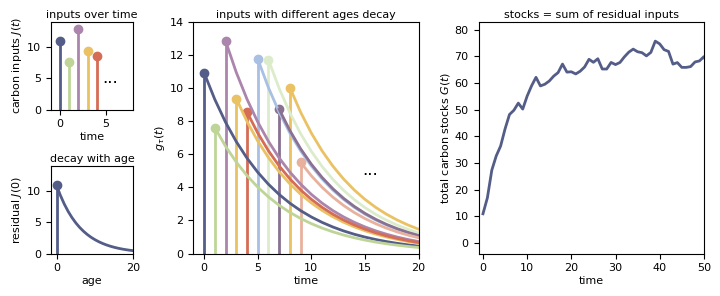

In [17]:
mosaic = 'ACCDD\nBCCDD'
fig, axs = plt.subplot_mosaic(mosaic, layout='constrained', figsize=(7.25, 3))

plt.sca(axs['A'])
# stem plot of J_t

for i, (J, color) in enumerate(zip(J_t[:5], color_order[:5])):
    plt.stem(i, J, color)
    
plt.xlabel('time')
plt.xticks(np.arange(0, 8, 5))
plt.xlim(-1, 8)
plt.ylim(0, 14)
plt.text(5.5, 5, '...', fontsize=12, ha='center', va='center')
plt.ylabel(r'carbon inputs $J(t)$')
plt.title('inputs over time')

plt.sca(axs['B'])
plt.stem(0, J_t[:1], color_order[0])
ages = np.arange(100)
plt.plot(ages, decay(J_t[0], ages), color=color_order[0])
plt.xlabel('age')
#plt.xticks(np.arange(len(J_t)))
plt.xlim(-1.5, 20)
plt.ylim(0, 14)
plt.ylabel(r'residual $J(0)$')
plt.title('decay with age')

plt.sca(axs['C'])

# Only have 10 colors -- plot the first 10
for i, (J, color) in enumerate(zip(J_t[:10], color_order[:10])):
    plt.stem(i, J, color)

g_ts = np.zeros((len(J_t), len(ages)+len(J_t) + 10))
for i in range(len(J_t)):
    decay_i = decay(J_t[i], ages)
    g_ts[i, i:i+len(decay_i)] = decay_i

    # plot the first 10 only 
    if i >= 10:
        continue
    plt.plot(ages + i, decay_i, color=color_order[i])
plt.xlabel('time')
plt.ylabel(r'$g_\tau(t)$')
plt.text(15.5, 5, '...', fontsize=12, ha='center', va='center')
plt.xlim(-1, 20)
plt.ylim(0, 14)
plt.title('inputs with different ages decay')

G_t = np.sum(g_ts, axis=0)
plt.sca(axs['D'])
plt.plot(G_t, color=color_order[0])
plt.xlabel('time')
plt.xlim(-1, 50)
plt.ylabel(r'total carbon stocks $G(t)$')
plt.title(r'stocks = sum of residual inputs')

plt.tight_layout()